# Exercise Set 1: 5+

## Exercise 5

## Import .py functions and libraries

In [1]:
import numpy as np
import os
from numpy.polynomial.hermite import hermgauss
from scipy import interpolate
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# Set working directory
import os
os.getcwd()
os.chdir('/Users/ditlevkf/Ditlev/KU/Kandidaten/DP')

In [3]:
# Import standard parameters of the model. Par is a class with model parameters
from Functions.model_setup import par

In [4]:
# Import functions
from Functions import VFI as vfi

## 5.1-5.4 Solve and simulate model

In [5]:
# Get solution path

##### Possible changes to parameters of the model #####
# par.sigma_zeta = 0 # If we do this, all consumption paths are the same for the N individuals
# par.NM = 100
# par.T = 200
#######################################################

Cstar, Vstar = vfi.vfi_finite(par)

In [6]:
# Simulate consumption path
simC = vfi.simulate_path(Cstar,par)

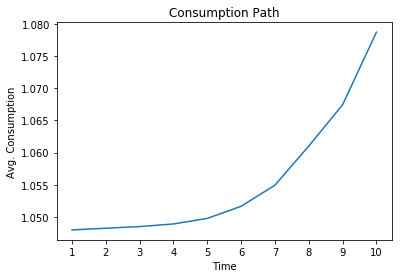

In [7]:
# Check that average of Ct is increasing over time
simC_mean = [np.mean(simC[:,x]) for x in range(par.T)]

plt.figure()
x = np.linspace(1,par.T,par.T)
plt.plot(x,simC_mean)
plt.title('Consumption Path'); plt.ylabel('Avg. Consumption'); plt.xlabel('Time'); plt.xticks(range(1,11))
plt.show()

## 5.5-5.8 Euler Errors (for period 1 and 2)

In [8]:
# Marginal utility function
marg_u = lambda C,par: C**(-par.rho)

# 1) Interpolants
Cstar_interp = interpolate.interp1d(par.grid_M, Cstar[1], kind='linear', fill_value = "extrapolate")
Cstar_plus_interp = interpolate.interp1d(par.grid_M, Cstar[2], kind='linear', fill_value = "extrapolate")

# 2) Consumption today and tomorrow
C = Cstar_interp(par.M_ini)
A = par.M_ini - C
C_plus = Cstar_plus_interp(A+par.R * par.Y) # Notice, this is an array due to Gauss-Hermite

# 3.1) Euler errors
euler_error = abs(marg_u(C,par) - par.beta * par.R * sum(par.w * marg_u(C_plus,par)))
# 3.2) Normalized euler errors
norm_euler_error = np.log10(euler_error/C)

# 4) Print
print('The normalized euler error is', norm_euler_error)

The normalized euler error is -3.198723135665679


# Exercise 6: Infinite Horizon

In [9]:
par.max_iter = 500
par.M_max = 5
par.NM = 100
par.R = 1
par.tolerance = 10**-3
par.beta = 0.9

In [10]:
Cstar_inf, Vstar_inf, iterations = vfi.vfi_infinite2(par) # Has keyboard interrupt hotkey
print('It took', iterations, 'iterations for the algorithm to converge')

It took 74 iterations for the algorithm to converge


In [11]:
Cstar_inf, Vstar_inf, iterations = vfi.vfi_infinite(par)
print('It took', iterations, 'iterations for the algorithm to converge')

It took 74 iterations for the algorithm to converge


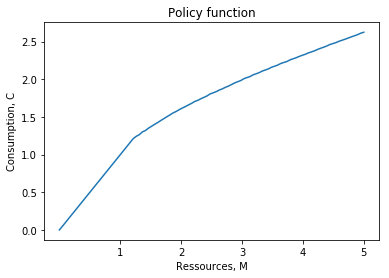

In [12]:
plt.figure()
plt.plot(par.grid_M,Cstar_inf)
plt.title('Policy function'); plt.ylabel('Consumption, C'); plt.xlabel('Ressources, M'); plt.xticks(range(1,6))
plt.show()

# Exercise 7: Function Approximation

## 7.1 

In [13]:
# Function to be interpolated
def f(x):
    #output = min(np.max((-1, 4*(x-0.2))),1)
    #output = np.max((-1, 4 * (x - 0.2)))
    output = np.maximum(-1, 4 * (x - 0.2))
    output = np.minimum(1,output)
    return(output)

In [14]:
# Data available
interval = (-1,1)
N_true = 1000
N_known = 10
N = 50

# a) Function values
x_true = np.linspace(interval[0], interval[1], N_true)
f_true = f(x_true)

# b) Grid
G = np.linspace(interval[0], interval[1], N)

# c) Grid points where the function is known
Min = interval[0] - interval[0] * 0.2
Max = interval[1] - interval[1] * 0.2

x_known = np.linspace(interval[0], interval[1], N_known)
f_known = f(x_known)

# d) Linear interpolation
f_linear_interp = interpolate.interp1d(x_known, f_known, kind='linear', fill_value = "extrapolate")
f_linear = f_linear_interp(G)

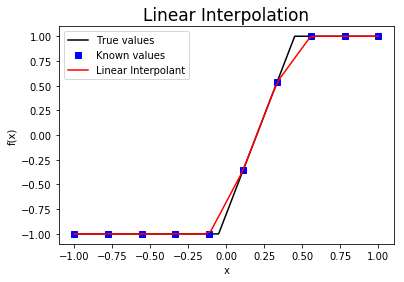

In [15]:
plt.figure()
plt.plot(x_true,f_true, color = "k", label = "True values")
plt.plot(x_known,f_known, 'bs', label = "Known values")
plt.plot(G,f_linear, color = 'r', label = "Linear Interpolant")
plt.title('Linear Interpolation', size = 17); plt.ylabel('f(x)'); plt.xlabel('x');
plt.legend()
plt.show()

## 7.1 a) Cubic Spline

In [16]:
f_cubic_interp = interpolate.interp1d(x_known, f_known, kind='cubic', fill_value = "extrapolate")
f_cubic = f_cubic_interp(G)

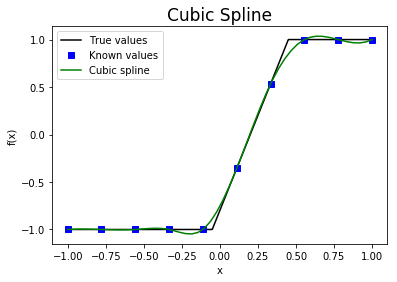

In [17]:
plt.figure()
plt.plot(x_true,f_true, color = "k", label = "True values")
plt.plot(x_known,f_known, 'bs', label = "Known values")
#plt.plot(G,f_linear, color = 'r', label = "Linear Interpolant")
plt.plot(G, f_cubic, color = 'g', label = "Cubic spline")
plt.title('Cubic Spline', size = 17); plt.ylabel('f(x)'); plt.xlabel('x');
plt.legend()
plt.show()

## 7.1 b) Regression with d = 4 polynomial

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
poly = PolynomialFeatures(degree = 4)

# Polynomials
x_known_poly = np.reshape(x_known, (-1,1)) # Need to reshape array for it to work
G_poly = np.reshape(G, (-1,1))
x_poly = poly.fit_transform(x_known_poly)
G_poly = poly.fit_transform(G_poly)

# Regression
lin = LinearRegression()
lin.fit(x_poly, f_known)
f_poly_reg = lin.predict(G_poly)

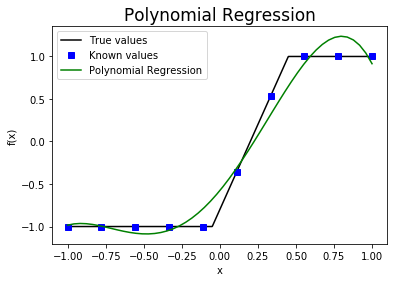

In [19]:
plt.figure()
plt.plot(x_true,f_true, color = "k", label = "True values")
plt.plot(x_known,f_known, 'bs', label = "Known values")
#plt.plot(G,f_linear, color = 'r', label = "Linear Interpolant")
#plt.plot(G, f_cubic, color = 'g', label = "Cubic spline")
plt.plot(G, f_poly_reg, color = 'g', label = "Polynomial Regression")

plt.title('Polynomial Regression', size = 17); plt.ylabel('f(x)'); plt.xlabel('x');
plt.legend()
plt.show()

# Exercise 8: Taste Shocks

## Set Parameters

In [20]:
par.T = 10
par.beta = 0.98
par.rho = 0.5
par.lambda_ = 1.3 # can't use 'lambda'
par.R = 1.0/par.beta
par.W = 1
par.sigma_eps = 0.5

## 8.1 Solve model

In [21]:
Vstar, Cstar = vfi.vfi_finite_tasteshocks(par)

## 8.2 Plot choice-specific value function

In [22]:
V_1_L0 = Vstar[1,0]
V_1_L1 = Vstar[1,1]

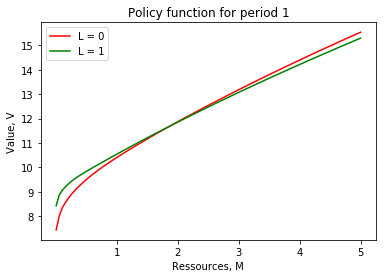

The higher the ressources, the lower the value of working


In [23]:
plt.figure()
plt.plot(par.grid_M,V_1_L0, color = 'r', label = 'L = 0')
plt.plot(par.grid_M,V_1_L1, color = 'g', label = 'L = 1')

plt.title('Policy function for period 1'); plt.ylabel('Value, V'); plt.xlabel('Ressources, M'); plt.xticks(range(1,6))
plt.legend()
plt.show()

print('The higher the ressources, the lower the value of working')

### 8.2.2 Choice functions

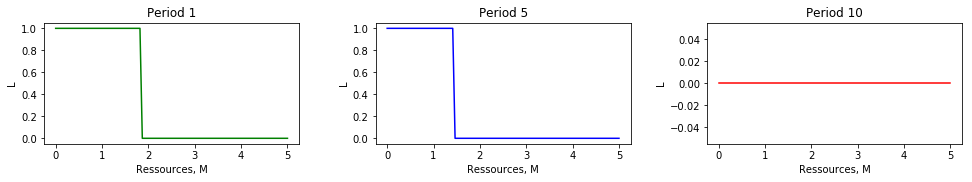

In [24]:
t = [1,5,10]
plt.subplots(1,3,figsize=(15,2))
plt.subplot(131)
L = (Vstar[t[0],1] > Vstar[t[0],0]) * 1
plt.ylabel('L'); plt.xlabel('Ressources, M')
plt.title('Period 1')
plt.plot(par.grid_M,L, color = 'g')

plt.subplot(132)
L = (Vstar[t[1],1] > Vstar[t[1],0]) * 1
plt.ylabel('L'); plt.xlabel('Ressources, M')
plt.title('Period 5')
plt.plot(par.grid_M,L, color = 'b')

plt.subplot(133)
L = (Vstar[t[2],1] > Vstar[t[2],0]) * 1
plt.ylabel('L'); plt.xlabel('Ressources, M')
plt.title('Period 10')
plt.plot(par.grid_M,L, color = 'r')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.3)
plt.show()

### 8.3 Simulate from model

In [25]:
par.simN = 100000
par.M_ini = 1.5
simC, simL = vfi.simulate_path_tasteshock(Vstar,Cstar,par)

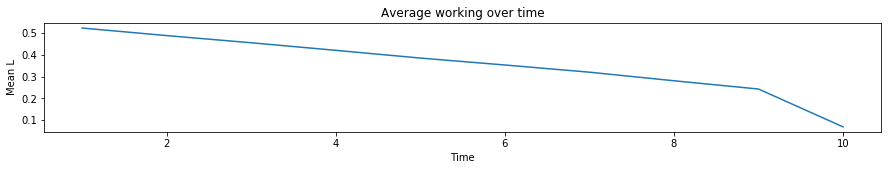

In [26]:
simL_mean = np.mean(simL, axis = 0)

plt.figure(figsize=(15,2))
x = np.linspace(1,par.T,par.T)
plt.plot(x,simL_mean)

plt.ylabel('Mean L'); plt.xlabel('Time')
plt.title('Average working over time')
plt.show()

In [27]:
simL_mean

array([0.52306, 0.48829, 0.45545, 0.42072, 0.38526, 0.35349, 0.32048,
       0.28114, 0.2432 , 0.06967])

# Exercise 9